In [1]:
!mkdir -p ./kaggle
!cp kaggle_emotion.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 94% 57.0M/60.3M [00:02<00:00, 42.0MB/s]
100% 60.3M/60.3M [00:02<00:00, 30.2MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

## Installing Packages

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

## Setting up Directory to save model data

In [5]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (Here, Google Colab Workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

# Create a subdirectory for each model
for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok = True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


## Data Cleaning

In [6]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files:
    # Construct the path to the current file
    file_path = os.path.join(root, file)

    try:
      # Check the file type of the current file
      file_type = imghdr.what(file_path)

      # If the file extension is not in the allowed list, remove it
      if file_type not in image_exts:
        print(f'Image not in ext list {fle_path}')
        os.remove(file_path)
      else:
        # Proceed to process the image if needed, for example, reading it with OpenCV
        img = cv2.imread(file_path)

    except Exception as e:
      # Print out the issue and the path of the problematic file
      print(f'Issue wth file {file_path}. Error: {e}')
      # Optionally, remove files that cause exceptions
      os.remove(file_path)


## Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
  # Initialize an empty dictionary to hold the count of files for each subdirectory.
  counts = {}

  # Iterate over each item in the given directory
  for item in os.listdir(directory):
    # Construct the full path to the item.
    item_path = os.path.join(directory, item)

    # Check if the item is a directory
    if os.path.isdir(item_path):
      # Count the number of files in the subdirectory and add it to the dictionary.
      counts[item] = len(os.listdir(item_path))

  # Convert the counts dictionary to a Dataframe for easy viewing and analysis.
  # The index of the DataFrame is set to the provided set name.
  df = pd.DataFrame(counts, index = [set_name])
  return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       surprise  happy  neutral  disgust  angry  fear   sad
train      3171   7215     4965      436   3995  4097  4830
      surprise  happy  neutral  disgust  angry  fear   sad
test       831   1774     1233      111    958  1024  1247


<Axes: >

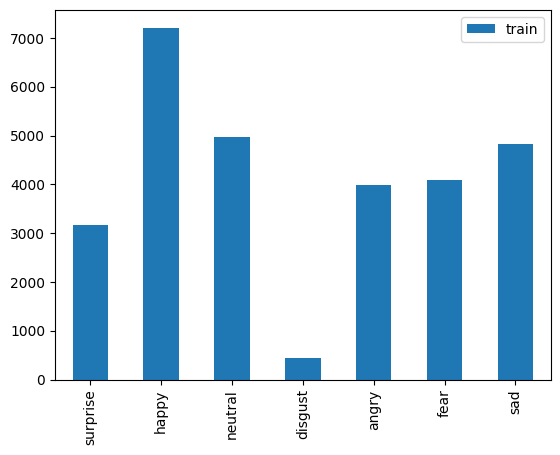

In [ ]:
train_count.transpose().plot(kind = 'bar')

<Axes: >

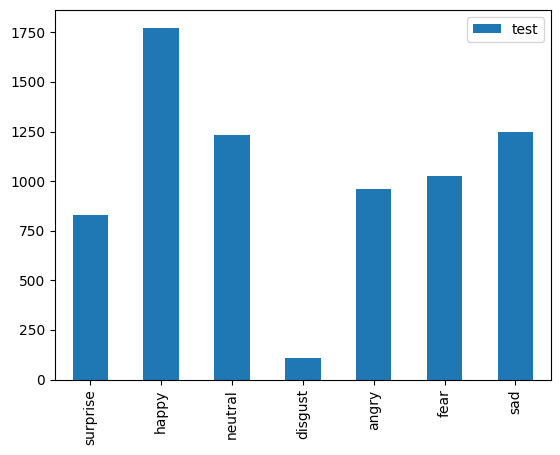

In [ ]:
test_count.transpose().plot(kind = 'bar')

## Plotting one image from each emotion

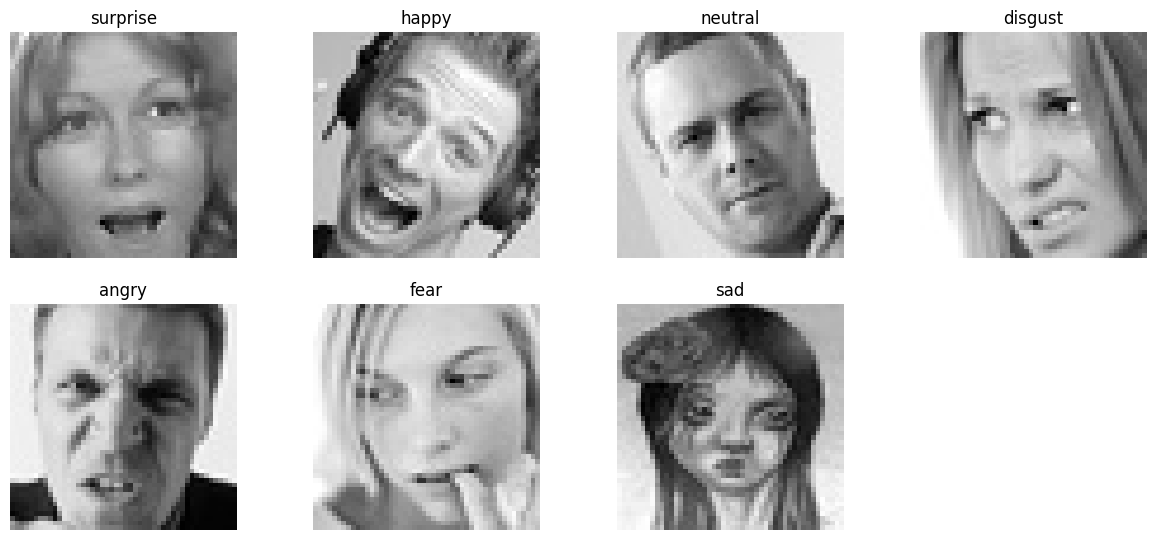

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[45])
  img = plt.imread(img_path)
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

## Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

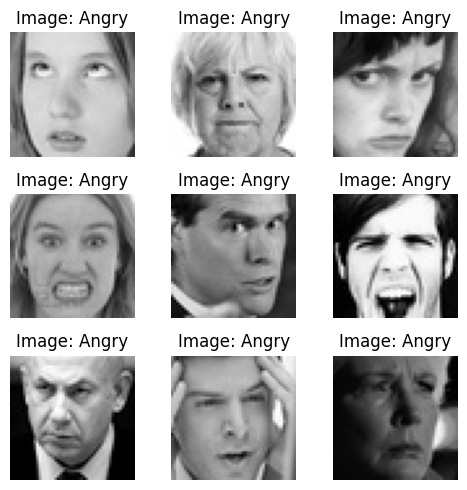

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

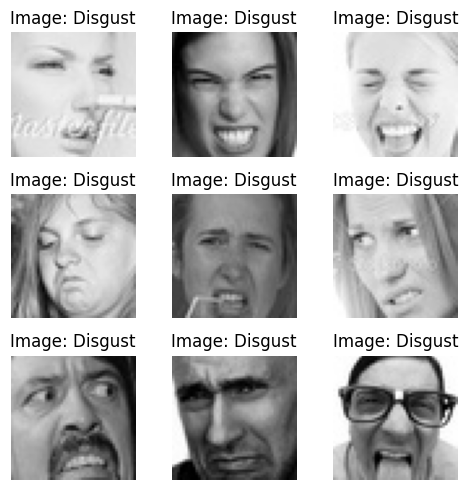

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

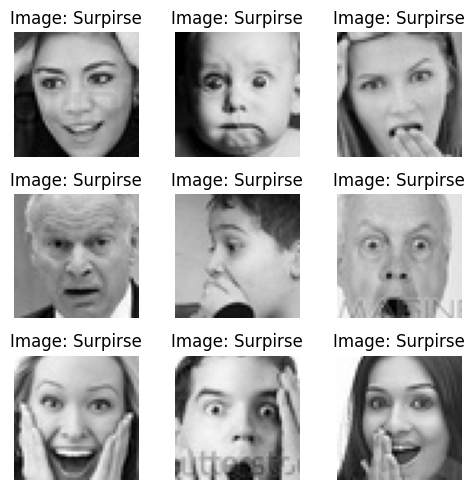

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

## Checking shapes and channels

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN From Scratch

## Initializing the ImageGenerators

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7   # Update this based on the number of classes

In [ ]:
# Rescale the pixel values (0-255) to the [0,1] interval
data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels: ", validation_class_labels)

# Accessing class labels for the test data
test_class_labels = test_generator.class_indices
print("Test class labels: ", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size = (3, 3), kernel_initializer = 'glorot_uniform', padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3),  kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
# Compiling the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

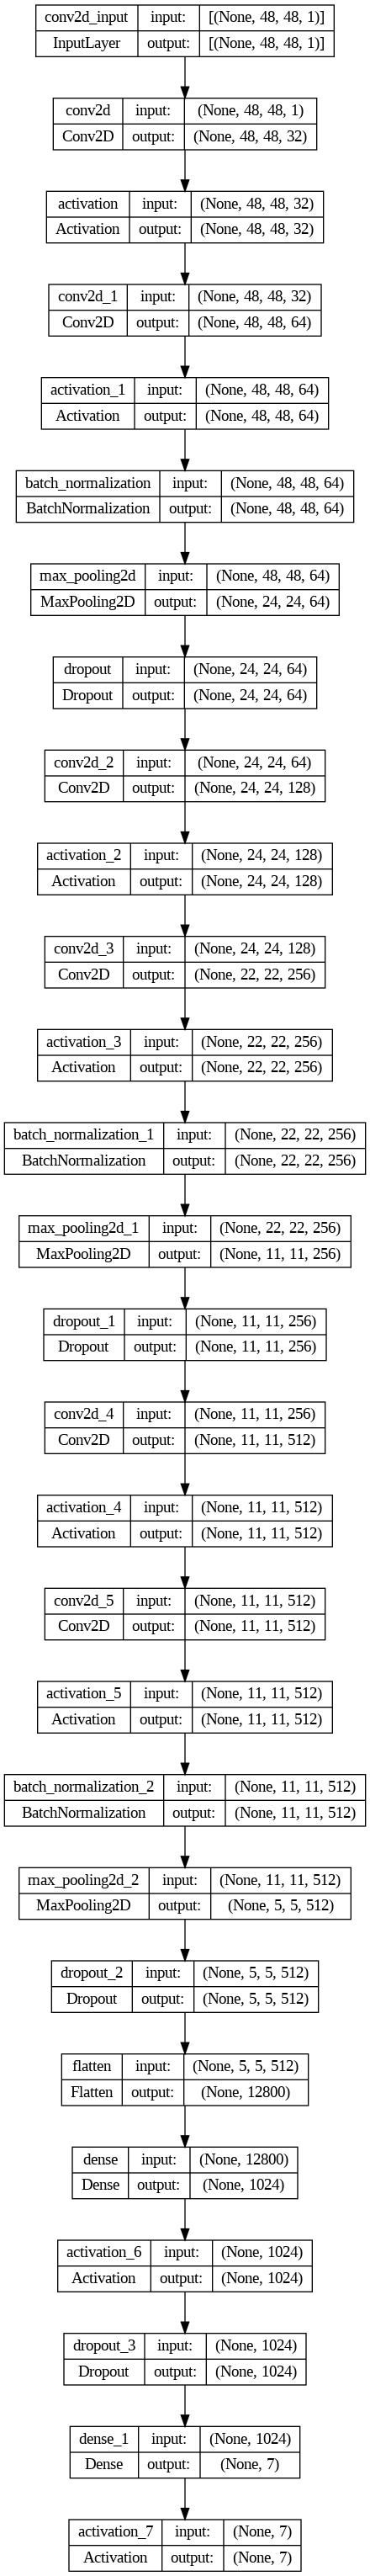

In [ ]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes = True,
           show_layer_names = True)

## Understanding Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             monitor = 'val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
# Callback for reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

## Calculating Steps for epoch

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

## Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4547 - accuracy: 0.2650
Epoch 1: val_loss improved from inf to 14.33139, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 38s 78ms/step - loss: 12.4547 - accuracy: 0.2650 - val_loss: 14.3314 - val_accuracy: 0.1825 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2209 - accuracy: 0.3454
Epoch 2: val_loss improved from 14.33139 to 9.61084, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 25s 69ms/step - loss: 10.2209 - accuracy: 0.3454 - val_loss: 9.6108 - val_accuracy: 0.3738 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1755 - accuracy: 0.3896
Epoch 3: val_loss improved from 9.61084 to 7.25734, saving model to /content/FER_2013_Emotion_Detection/Cus

## Plotting Performance Metrics

In [7]:
def plot_training_history(history):
  """
  Plots the training and validation accuracy and loss.

  Parameters:
   - history: A Keras History object. Contains the logs from the training process.

   Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize = (20, 5))

  # Plot training and validation accuracy
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label = 'Training Accuracy')
  plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right')
  plt.title('Training and Validation Accuracy')

  # Plot training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'upper right')
  plt.title('Training and Validation Loss')

  plt.show()

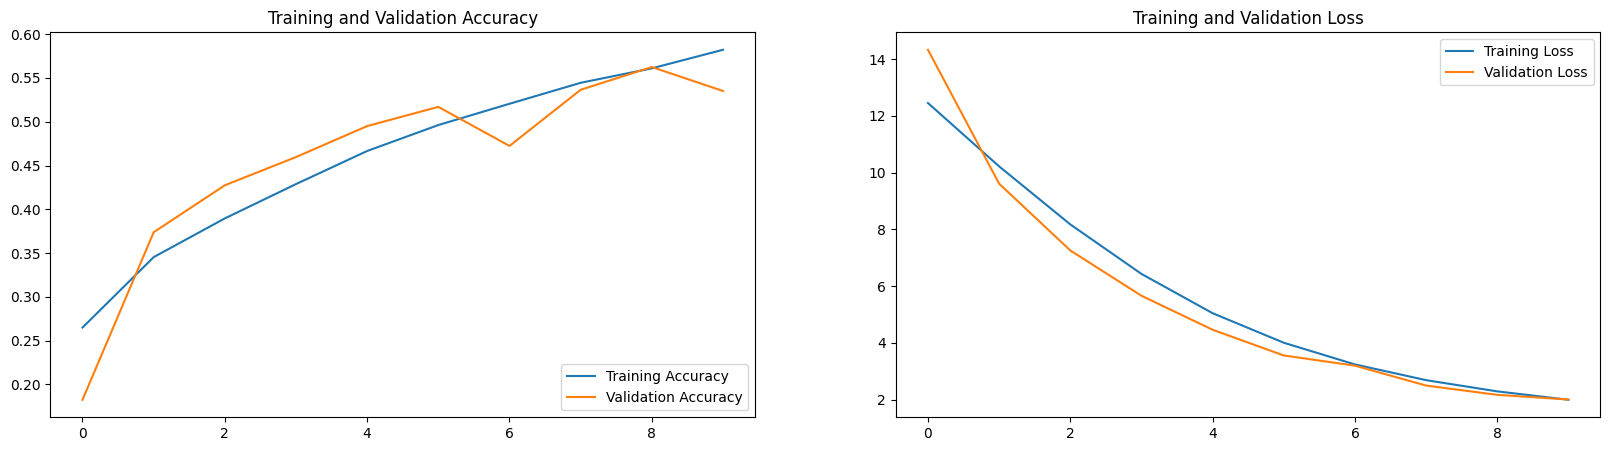

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("Final train accuracy = {:.2f}, validation accuracy = {:.2f}".format(train_accu * 100, test_accu * 100))

113/113 [==============================] - 3s 28ms/step - loss: 1.9989 - accuracy: 0.5371
Final train accuracy = 61.46, validation accuracy = 53.71


## Plotting Confusion Matrix

113/113 [==============================] - 3s 21ms/step


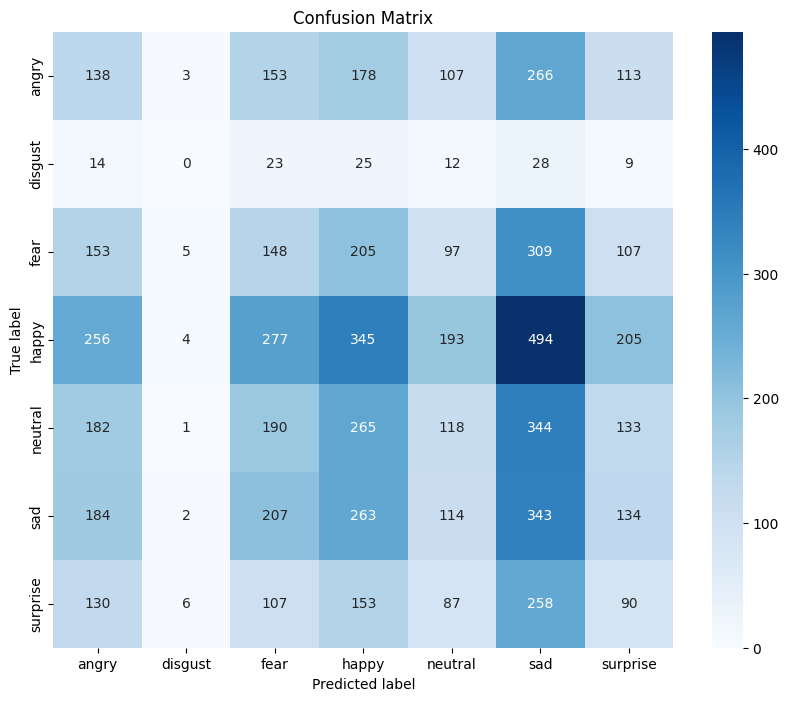

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples / test_generator.batch_size)), axis = 1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print("Clsassification Report: \n", report)

Clsassification Report: 
               precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.14      0.14      1024
       happy       0.24      0.19      0.22      1774
     neutral       0.16      0.10      0.12      1233
         sad       0.17      0.28      0.21      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.16      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.16      0.16      7178



## Making Predictions

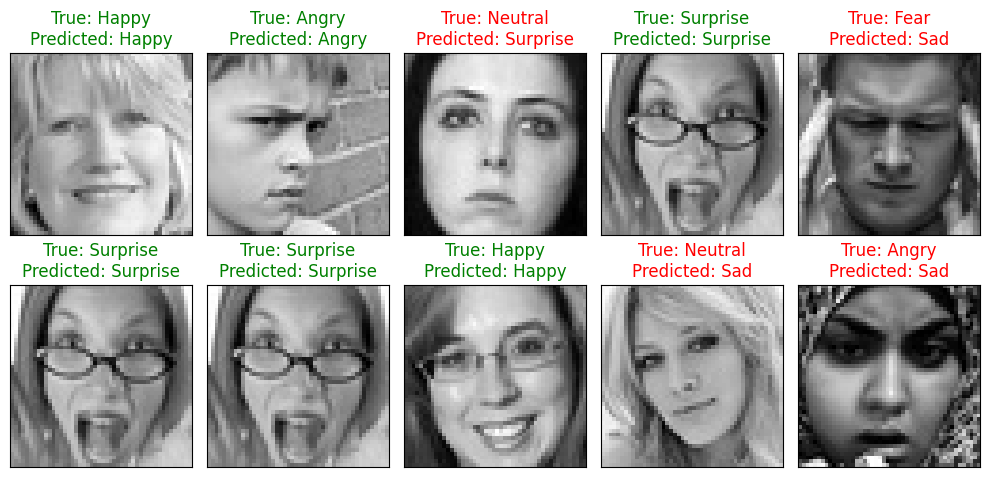

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  # Fetching the random image and its label
  Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
  Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

  # Making a prediction using the model
  Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

  # Displaying the image
  ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
  # Setting the title with true and predicted labels, colored based on correctness
  color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
  ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model 2: Image Augmentation

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48    # Size of images
batch_size = 64
epochs = 10
num_classes = 7 # Update this based on the number of your classes


# Initoalizing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale = 1./255, # Rescale the pixel values from [0,255] to [0,1]
    rotation_range = 40,  # Degree range for random rotations
    width_shift_range = 0.2,# Range (as a fraction of total width) for random horizontalshifts
    height_shift_range = 0.2,# Range (as a fraction of total height) for random vertical shifts
    shear_range = 0.2,# Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range = 0.2,   # Range for random zoom
    horizontal_flip = True, # Randomly flip inputs horizontally
    fill_mode = 'nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split = 0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale = 1./255)


# Automatically retrive images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


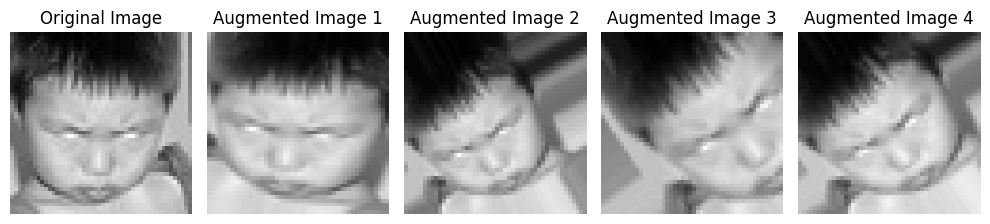

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Same CNN Model as above

In [ ]:
# Assuming img_width, imig_height, and classes are defined.
img_width, img_height = 48, 48
classes = 7

# Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             monitor = 'val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau (monitor = 'val_loss',
                               factor = 0.2,
                               patience = 6,
                               verbose = 1,
                               min_delta = 0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks
)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.4878 - accuracy: 0.2204
Epoch 1: val_loss improved from inf to 12.33392, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 35s 88ms/step - loss: 12.4878 - accuracy: 0.2204 - val_loss: 12.3339 - val_accuracy: 0.1791 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.2617 - accuracy: 0.2419
Epoch 2: val_loss improved from 12.33392 to 9.63787, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 31s 87ms/step - loss: 10.2617 - accuracy: 0.2419 - val_loss: 9.6379 - val_accuracy: 0.2432 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.1801 - accuracy: 0.2494
Epoch 3: val_loss improved from 9.63787 to 7.42624, saving model to /conte

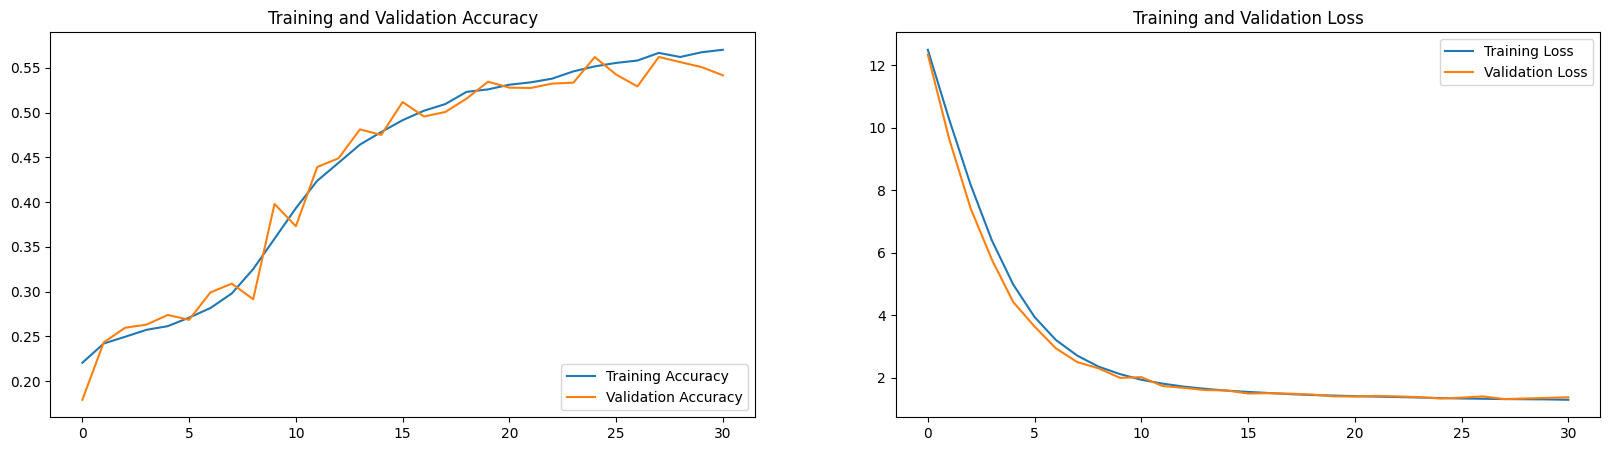

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("Final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 29ms/step - loss: 1.2310 - accuracy: 0.5947
Final train accuracy = 57.92 , validation accuracy = 59.47


113/113 [==============================] - 4s 30ms/step


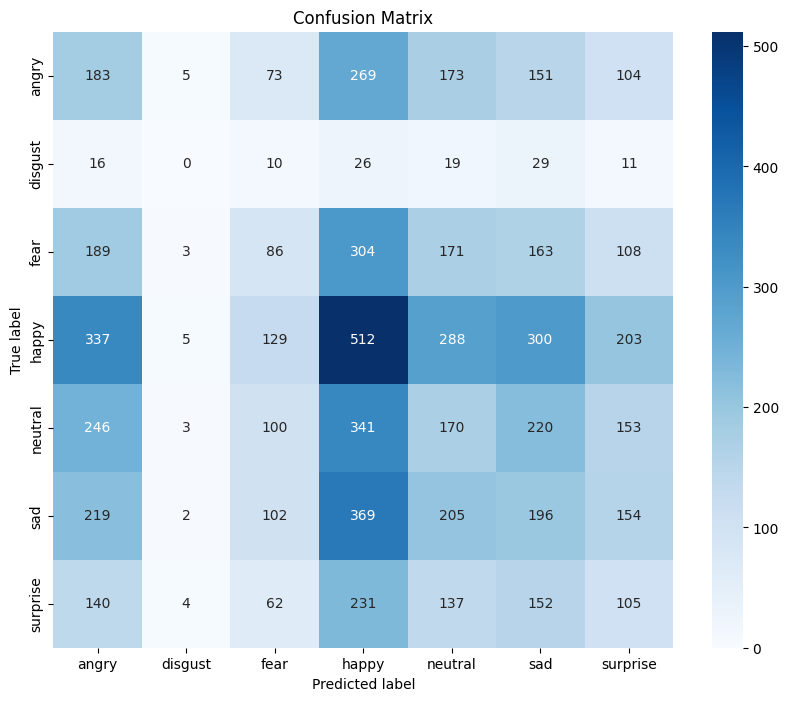

In [ ]:
# Assuming yur true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples/test_generator.batch_size)), axis = 1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize = (10, 8))
sns.heatmap(cm,annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.19      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.08      0.11      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.15      0.14      0.14      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



## Model 3: Transfer Learning VGGNET

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224    # Size of images
batch_size = 64
epochs = 10
num_classes = 7   # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0,1] interval
data_generator = ImageDataGenerator(
    rescale = 1 / 255.,
    rotation_range = 10,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    # validation_split = 0.2
)

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training',
    shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',)
    # subset = 'validation)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = 7

# Clear the previous TensorFlow sessions
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
  layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He_normal initializer
x = Dense(1024, activation = 'relu', kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)   # Adding dropout for regularization

x = Dense(512, activation = 'relu', kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)   # Adding dropout for regularizarion

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation = 'softmax', kernel_initializer = 'he_normal')(x)

# Creating the model
model = Model(inputs = vgg.input, outputs = output)

# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False),
              metrics = ['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the modal checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             monitor = 'val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]    # Adjusted as per use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_data = test_generator,
                    validation_steps = test_steps_epoch,
                    epochs = 5,
                    callbacks = callbacks)

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.5946 - accuracy: 0.3762
Epoch 1: val_loss improved from inf to 1.34292, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 458s 983ms/step - loss: 1.5946 - accuracy: 0.3762 - val_loss: 1.3429 - val_accuracy: 0.4861 - lr: 1.0000e-04
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.4785
Epoch 2: val_loss improved from 1.34292 to 1.24669, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 442s 983ms/step - loss: 1.3606 - accuracy: 0.4785 - val_loss: 1.2467 - val_accuracy: 0.5259 - lr: 1.0000e-04
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.2847 - accuracy: 0.5105
Epoch 3: val_loss improved from 1.24669 to 1.20785, saving model to /content/FER_2013_Emotion_Detec

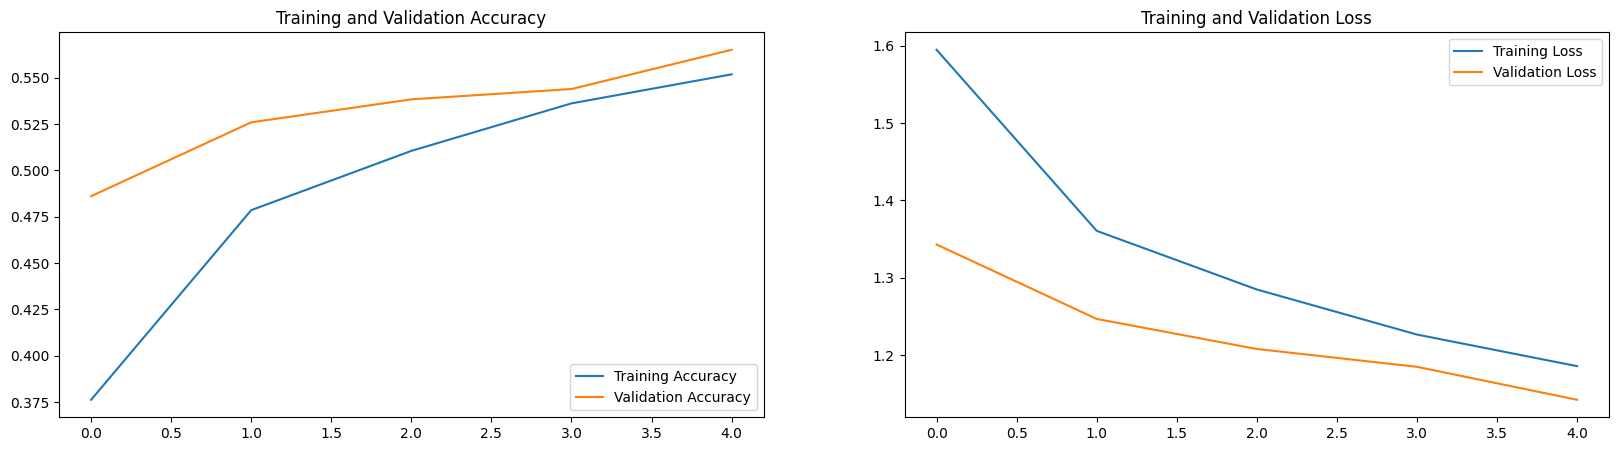

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("Final Train Accuracy = {:.2f} , Validation Accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 30s 262ms/step - loss: 1.1422 - accuracy: 0.5651
Final Train Accuracy = 57.56 , Validation Accuracy = 56.51


113/113 [==============================] - 29s 262ms/step


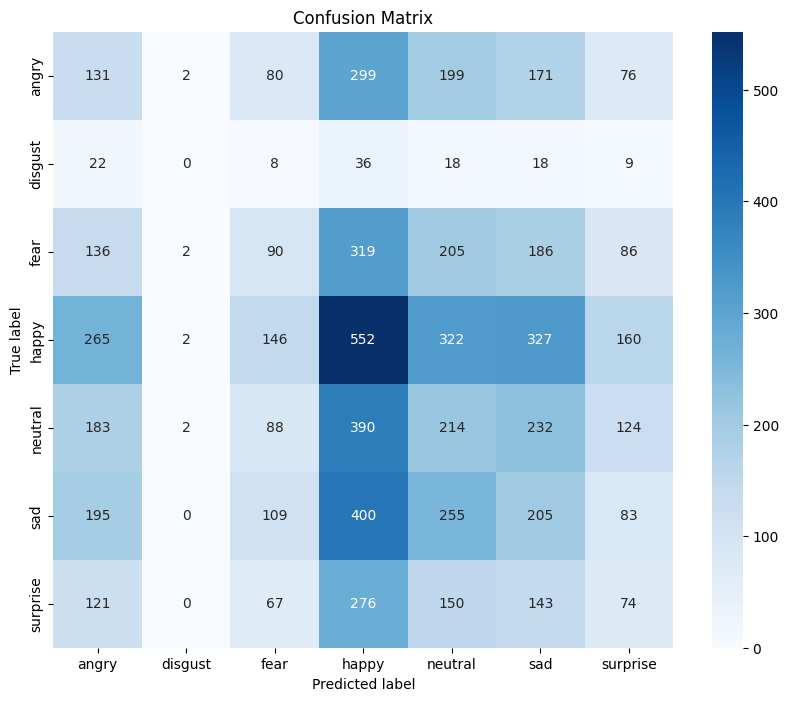

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples / test_generator.batch_size)), axis = 1)
class_labels = list(test_generator.class_indices.keys())

# Generate teh confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names = class_labels,
                               zero_division = 0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.14      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.09      0.11      1024
       happy       0.24      0.31      0.27      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.12      0.09      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



## Model 4: Transfer Learning - ResNet50

In [8]:
train_dir = '/content/train'
test_dir = '/content/test'

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rescale = 1/255,                # Rescale pixel values to [0,1]
    rotation_range = 40,            # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.2,        # Randomly horizontally shift images
    height_shift_range = 0.2,       # Randomly vertically shift images
    shear_range = 0.2,              # Apply shearing transformations
    zoom_range = 0.1,               # Randomly zoom image
    horizontal_flip = True,         # Randomly flip images horizontally
    fill_mode = 'nearest'           # Strategy used for filling in newly created pixels
)

# Rescaling for validation / test data (without further data augmentation)
test_datagen = ImageDataGenerator(
    rescale = 1/255           # Rescale pixel values to [0, 1]
)

# Creating data genetarors for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),     # Resize images to 224x224 for model input
    color_mode = 'rgb',           # Images will be converted to RGB
    class_mode = 'categorical',   # For multi-class classification
    batch_size = 32               # Size of the batches of data
)

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),        # Resize images to 224x224 for model input
    color_mode = 'rgb',              # Images will be converted to RGB
    class_mode = 'categorical',      # For multi-class classification
    batch_size = 32                  # Size of the batches of data
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Introdoucing Class Weights for Imbalanced Data

In [9]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculated class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight = 'balanced',        # Strategy to balance classes
    classes = np.unique(classes),     # Unique class labels
    y = classes                       # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [10]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    Dropout(0.1),
    Dense(512, activation = 'relu'),
    Dropout(0.1),
    Dense(128, activation = 'relu'),
    Dropout(0.1),
    Dense(7, activation = 'softmax')
])

optimizer = Adamax(learning_rate = 0.0001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [11]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             monitor = 'val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

# Callback to log training data to a csv file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]   # Adjust as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [12]:
train_history = model.fit(
    train_generator,
    steps_per_epoch = 200,
    epochs = 40,
    validation_data = test_generator,
    validation_steps = 100,
    class_weight = class_weights_dict,
    callbacks = callbacks
)

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: 1.9190 - accuracy: 0.2248
Epoch 1: val_loss improved from inf to 1.83923, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 149s 577ms/step - loss: 1.9190 - accuracy: 0.2248 - val_loss: 1.8392 - val_accuracy: 0.2806
Epoch 2/40
200/200 [==============================] - ETA: 0s - loss: 1.8432 - accuracy: 0.2839
Epoch 2: val_loss improved from 1.83923 to 1.78273, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 114s 571ms/step - loss: 1.8432 - accuracy: 0.2839 - val_loss: 1.7827 - val_accuracy: 0.3013
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: 1.7423 - accuracy: 0.3166
Epoch 3: val_loss improved from 1.78273 to 1.55827, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Trans

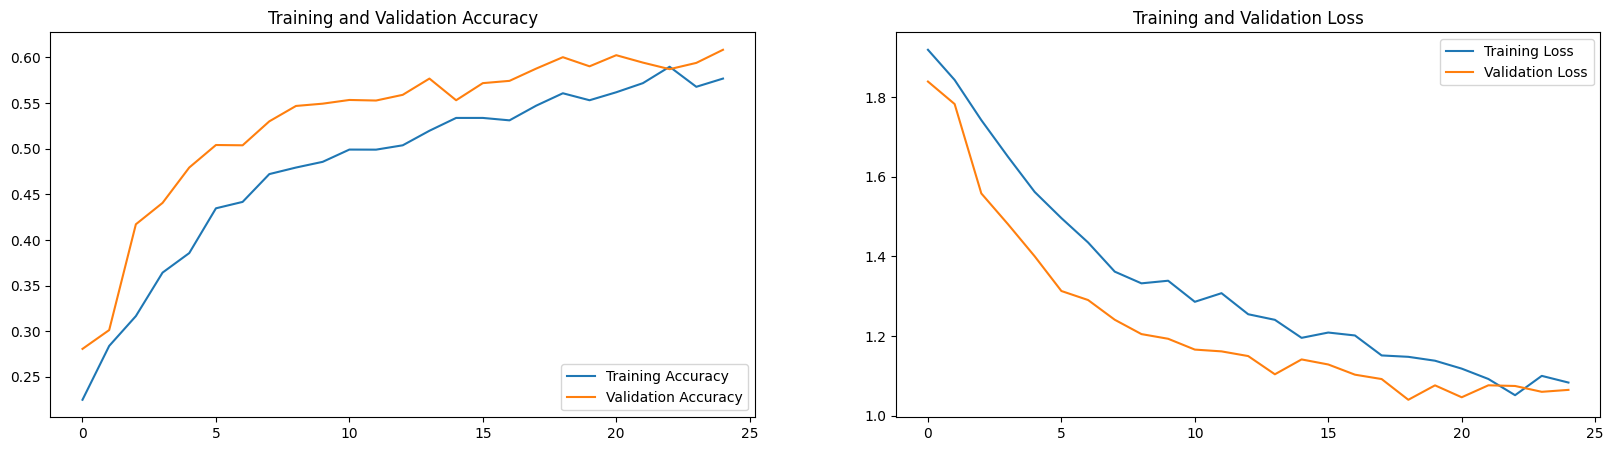

In [13]:
plot_training_history(train_history)

In [14]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 21s 92ms/step - loss: 1.0713 - accuracy: 0.5883
final train accuracy = 58.87 , validation accuracy = 58.83


225/225 [==============================] - 20s 90ms/step


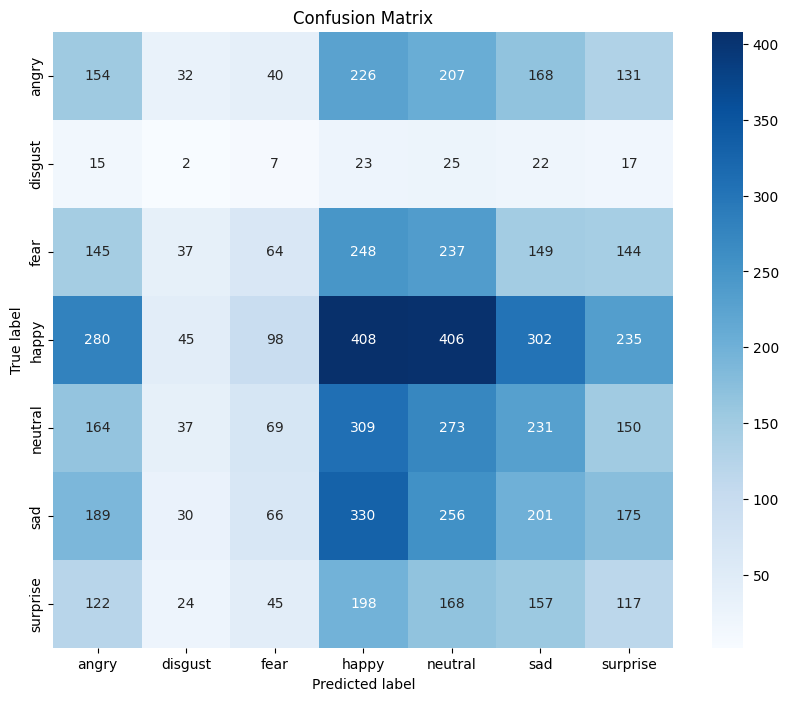

In [16]:
# Assuming true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples / test_generator.batch_size)), axis = 1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names = class_labels,
                               zero_division = 0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.16      0.15       958
     disgust       0.01      0.02      0.01       111
        fear       0.16      0.06      0.09      1024
       happy       0.23      0.23      0.23      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.12      0.14      0.13       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



## AUC ROC plot for each class

In [18]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps = len(test_generator))
pred_labels = np.argmax(preds, axis = 1)
classes = list(test_generator.class_indices.keys())

225/225 [==============================] - 18s 82ms/step


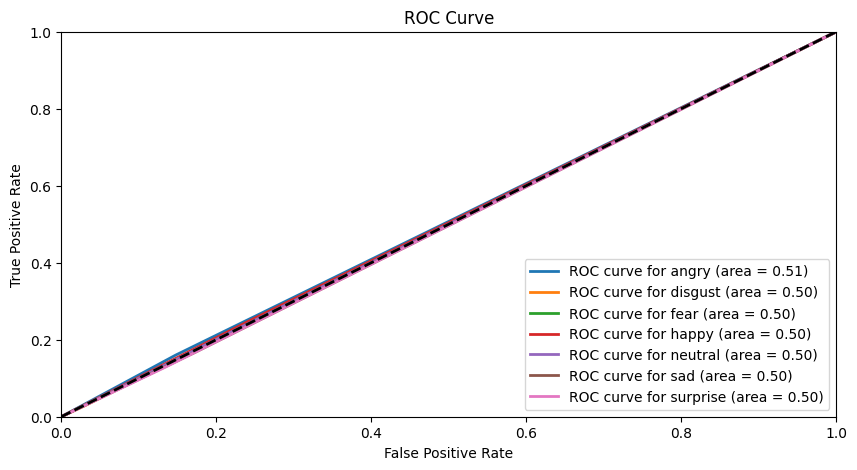

In [19]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
  fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (10, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
  plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')

## Push all your models into Drive for easy access

In [32]:
!cp -r /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

## Deployment

## Gradio

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/s e

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import tensorflow as tf
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image


In [4]:
# Ensure model is loaded here
# model = .... # Load your trained model
# Load pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras')


In [5]:
# Emotion labels dictionary
emotion_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'surprise':6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion


{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [6]:
def prepare_image(img_pil):
  """ Preprocess the PIL Image to fit your model's input requirements. """
  # Convert the PIL image to a numpy array with the target size
  img = img_pil.resize((224,224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis = 0)   # Convert single image to batch
  img_array /= 255.0    # Rescale pixel values to [0,1], as done during training
  return img_array


# Define the Gradio Interface
def predict_emotion(image):
  # Preprocess the image
  processed_image = prepare_image(image)
  # Make prediction using the model
  prediction = model.predict(processed_image)
  # Get the emtion label with the highest probability
  predicted_class = np.argmax(prediction, axis=1)
  predicted_emotion = index_to_emotion.get(predicted_class[0], 'Unkown Emotion')
  return predicted_emotion


interface = gr.Interface(
    fn = predict_emotion,  # Your emotion function
    inputs = gr.Image(type = 'pil'),  # Input for uploading an image, directly compatible with PIL Images
    outputs = 'text',   # Output as text displaying the predicted emotion
    title = 'Emotion Detection',
    description = 'Upload an image and see the predicted emotion'
)

# Launch the Gradio Interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cede6a8befe4d86d2e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
